In [1]:
import optimization_SPDC_gaussain_pump as gauss_opt
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy
import jax.scipy.optimize as jax_opt

key = jax.random.PRNGKey(0) 
np.random.seed(0)

In [2]:
# power of the pump (if too high, may affect the loss function(increasing loss))
Np = 0.02
# create the frequency matrix ω-ω_mean (maybe also influences the quality of the backprop)
N = 701
wi = -7
wf = 7
x = np.linspace(wi, wf, N)
# get the group velocities for all modes
vp = 0.1
sigma = 1
a = 1.61/1.13
l = 1
def symmetric_v(vp, sigma, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sigma))
    vs = vp / (1 + 2 * a * vp / (l * sigma))
    return vs, vi
vs, vi = symmetric_v(vp, sigma, l, a)
# prefactor to multiply pump with to obtain F matrix
alpha = np.sqrt(Np)*(x[len(x) - 1] - x[0])/(len(x) - 1)/(np.sqrt(2 * np.pi * vs * vi * vp))
# initialize the G and H matrices without cross phase modulation
G = np.diag((1/vs - 1/vp)*x)
H = np.diag((1/vi - 1/vp)*x)
w = np.linspace(2*wi, 2*wf, 2*N)

In [3]:
def get_total_loss_gaussian(theta, w, alpha, G, H, l, y_N, y_K):
    loss_K = gauss_opt.get_euclidean_loss_K(theta, w, alpha, G, H, l, y_K)
    loss_N = gauss_opt.get_euclidean_loss_N(theta, w, alpha, G, H, l, y_N)
    return loss_K + loss_N

In [4]:
y_Ns = jnp.array([1, 2, 3, 4, 5, 10])
y_K = 1
phi = 2*np.pi*np.random.random()

In [5]:
initial_value = jnp.array([1., 1., 3*jnp.pi/7])

In [6]:
loss_on_K = []
thetas = []
gaussians = []
for i in range(len(y_Ns)):
    optimized = jax_opt.minimize(gauss_opt.get_loss, initial_value, args=(w, alpha, G, H, l, y_Ns[i]), method = "BFGS")
    optimized_theta = optimized.x
    loss_on_K.append(gauss_opt.get_loss(optimized_theta, w, alpha, G, H, l, y_Ns[i]))
    gaussians.append(optimized_theta[0]*jnp.exp(-(optimized_theta[1]*w)**2)*jnp.exp(1j*optimized_theta[2]))
    thetas.append(optimized_theta)
    print("N value: ", i)

N value:  0
N value:  1
N value:  2
N value:  3
N value:  4
N value:  5


In [7]:
gauss_opt.get_observable(thetas[-1], w, alpha, G, H, l)

(DeviceArray(10.000103, dtype=float32), DeviceArray(1.0370008, dtype=float32))

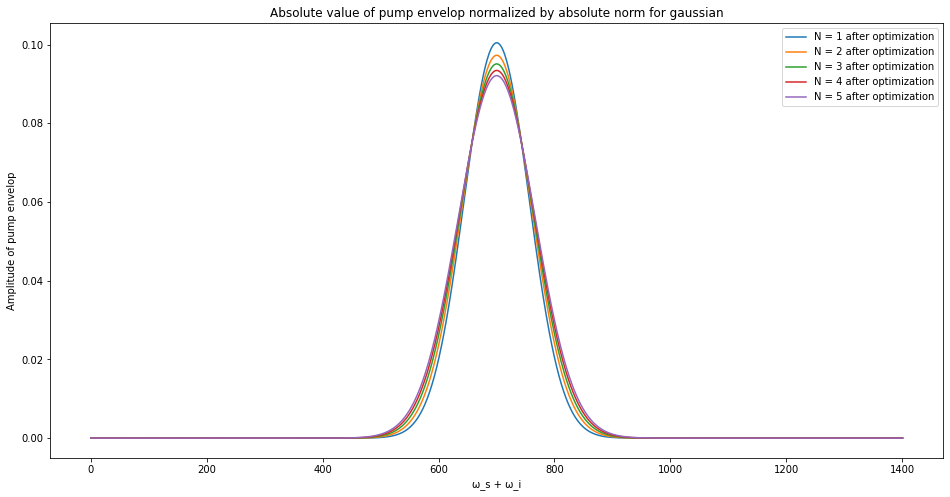

In [10]:
plt.figure(figsize = (16,8))
plt.title("Absolute value of pump envelop normalized by absolute norm for gaussian")
plt.xlabel("ω_s + ω_i")
plt.ylabel("Amplitude of pump envelop")
plt.plot(jnp.abs(gaussians[0]/(jnp.linalg.norm(gaussians[0]))), label = "N = 1 after optimization")
plt.plot(jnp.abs(gaussians[1]/(jnp.linalg.norm(gaussians[1]))), label = "N = 2 after optimization")
plt.plot(jnp.abs(gaussians[2]/(jnp.linalg.norm(gaussians[2]))), label = "N = 3 after optimization")
plt.plot(jnp.abs(gaussians[3]/(jnp.linalg.norm(gaussians[3]))), label = "N = 4 after optimization")
plt.plot(jnp.abs(gaussians[4]/(jnp.linalg.norm(gaussians[4]))), label = "N = 5 after optimization")
plt.legend()

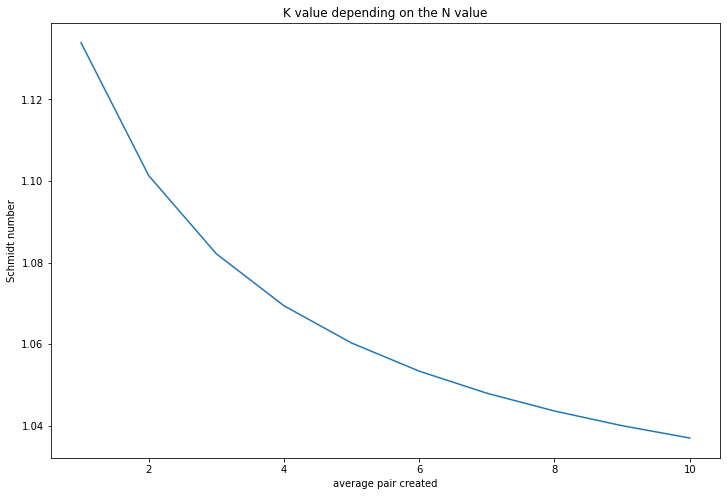

In [12]:
plt.figure(figsize = (12, 8))
plt.title("K value depending on the N value")
plt.xlabel("average pair created")
plt.ylabel("Schmidt number")
plt.plot(y_Ns, jnp.sqrt(jnp.array(loss_on_K))+1)